In [9]:
import typing
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def describe_contracts(contracts_df:pd.DataFrame):
    contracts_df['shares_per_contract'] = pd.to_numeric(contracts_df['shares_per_contract'], errors='coerce')
    contracts_df['strike_price'] = pd.to_numeric(contracts_df['strike_price'], errors='coerce')
    contracts_df['expiration_date'] = pd.to_datetime(contracts_df['expiration_date'], errors='coerce')

    display(contracts_df.head())
    display(contracts_df.describe(include='all'))


    strike_minmax = contracts_df.groupby('expiration_date')['strike_price'].agg(['min', 'max']).sort_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    x_dates = strike_minmax.index

    # Plot vertical lines for min/max
    ax.vlines(x_dates, strike_minmax['min'], strike_minmax['max'], color='tab:blue', lw=4, label='Strike Range')

    # Plot ticks for each strike price
    for i, exp_date in enumerate(x_dates):
        strikes = contracts_df[contracts_df['expiration_date'] == exp_date]['strike_price']
        # Plot each strike as a horizontal tick at the appropriate y
        ax.scatter([exp_date]*len(strikes), strikes, color='black', marker='_', s=120, label='Strike Price' if i == 0 else "")

    ax.set_xlabel("Expiration Date")
    ax.set_ylabel("Strike Price")
    ax.set_title("Strike Price Range")
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker
0,OCASPS,call,american,2025-01-02,BATO,100,400.0,O:SPY250102C00400000,SPY
1,OCASPS,call,american,2025-01-02,BATO,100,410.0,O:SPY250102C00410000,SPY
2,OCASPS,call,american,2025-01-02,BATO,100,420.0,O:SPY250102C00420000,SPY
3,OCASPS,call,american,2025-01-02,BATO,100,430.0,O:SPY250102C00430000,SPY
4,OCASPS,call,american,2025-01-02,BATO,100,440.0,O:SPY250102C00440000,SPY


,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker
count,738,738,738,738,738,738.0,738.000000,738,738
unique,2,2,1,NaN,1,NaN,NaN,738,1
top,OCASPS,call,american,NaN,BATO,NaN,NaN,O:SPY250102C00400000,SPY
freq,369,369,738,NaN,738,NaN,NaN,1,738
mean,NaN,NaN,NaN,2025-01-03 16:35:07.317073152,NaN,100.0,560.429539,NaN,NaN
min,NaN,NaN,NaN,2025-01-02 00:00:00,NaN,100.0,300.000000,NaN,NaN
25%,NaN,NaN,NaN,2025-01-02 00:00:00,NaN,100.0,535.000000,NaN,NaN
50%,NaN,NaN,NaN,2025-01-03 00:00:00,NaN,100.0,578.000000,NaN,NaN
75%,NaN,NaN,NaN,2025-01-06 00:00:00,NaN,100.0,607.000000,NaN,NaN
max,NaN,NaN,NaN,2025-01-06 00:00:00,NaN,100.0,700.000000,NaN,NaN


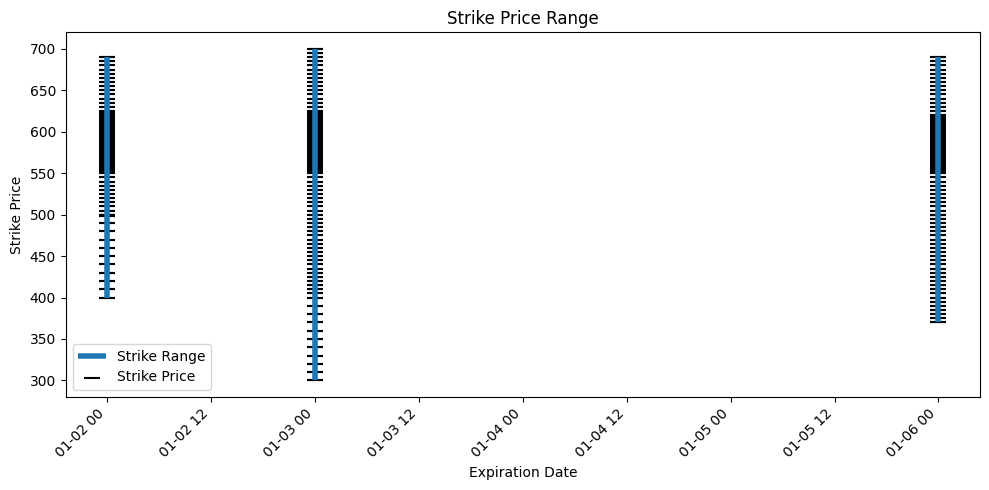

In [ ]:
contracts_fname:str  = "SPY_JAN_1_2025_JAN_7_2025.json"
notebook_dir = os.getcwd()
json_path = os.path.join(notebook_dir, "data", contracts_fname)  # Replace FILE-NAME.json as needed
with open(json_path, "r") as f:
    data = json.load(f)
contracts = data['results']
contracts_df = pd.DataFrame(contracts)

describe_contracts(contracts_df)

In [18]:
from typing import List, Dict, Optional
import pandas as pd
from typing import List, Dict, Any
import pandas as pd
from massive import RESTClient
from urllib3 import HTTPResponse
from dataclasses import asdict

from dotenv import load_dotenv
load_dotenv()

def fetch_contracts_df(
    ticker: str,
    exp_from: str,
    exp_to: str
) -> pd.DataFrame:
        
    client = RESTClient(api_key=os.getenv('MASSIVE_API_KEY'))

    base_params: Dict[str, Any] = {
        "underlying_ticker": ticker,
        "limit": 1000,
        "expired": True,
        # "order": "asc",
        # "sort": "expiration_date",
        # `as_of` defaults to "today"; you can set it explicitly if you want
        # "as_of": "2025-01-15",
    }

    filter_params = {
        "expiration_date.gte": exp_from,
        "expiration_date.lte": exp_to,
    }

    #all_contracts: List[Dict[str, Any]] = []
    contracts = client.list_options_contracts(**base_params,params=filter_params)
    if isinstance(contracts, HTTPResponse):
        raise ValueError("API request failed; check your API key and parameters.")

    all_contracts: List[Dict[str, Any]] = [asdict(c) for c in contracts]
    df = pd.DataFrame(all_contracts)

    return df



In [ ]:
import os
import pandas as pd
from massive import Massive

def fetch_prices_df(ticker, exp_from, exp_to, api_key=None):
    """
    Fetch options contracts for a ticker between exp_from and exp_to (YYYY-MM-DD), return as DataFrame.
    Uses Massive API Python client (free tier).
    """
    if api_key is None:
        api_key = os.getenv("MASSIVE_API_KEY")
    assert api_key, "Please provide your Massive API key via argument or MASSIVE_API_KEY env var."

    client = Massive(api_key=api_key)

    # Fetch contracts using Massive API client
    contracts = []
    for contract in client.options.contracts.list(
        symbol=ticker,
        expiration_from=exp_from,
        expiration_to=exp_to,
        limit=1000  # Free tier limit
    ):
        # The contract is a dataclass-like object; convert to dict
        contracts.append(contract.model_dump())

    df = pd.DataFrame(contracts)
    # Parse columns for consistency
    if not df.empty:
        if 'expiration_date' in df.columns:
            df['expiration_date'] = pd.to_datetime(df['expiration_date'], errors='coerce')
        if 'strike_price' in df.columns:
            df['strike_price'] = pd.to_numeric(df['strike_price'], errors='coerce')
        if 'shares_per_contract' in df.columns:
            df['shares_per_contract'] = pd.to_numeric(df['shares_per_contract'], errors='coerce')

    return df

# Example usage:
# df = fetch_prices_df("AAPL", "2024-07-01", "2024-07-31")
# display(df.head())

,additional_underlyings,cfi,contract_type,correction,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker
0,None,OCASPS,call,None,american,2025-02-07,BATO,100,100.0,O:AAPL250207C00100000,AAPL
1,None,OCASPS,call,None,american,2025-02-07,BATO,100,110.0,O:AAPL250207C00110000,AAPL
2,None,OCASPS,call,None,american,2025-02-07,BATO,100,120.0,O:AAPL250207C00120000,AAPL
3,None,OCASPS,call,None,american,2025-02-07,BATO,100,130.0,O:AAPL250207C00130000,AAPL
4,None,OCASPS,call,None,american,2025-02-07,BATO,100,140.0,O:AAPL250207C00140000,AAPL


,additional_underlyings,cfi,contract_type,correction,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker
count,0,124,124,0,124,124,124,124.0,124.000000,124,124
unique,0,2,2,0,1,NaN,1,NaN,NaN,124,1
top,NaN,OCASPS,call,NaN,american,NaN,BATO,NaN,NaN,O:AAPL250207C00100000,AAPL
freq,NaN,62,62,NaN,124,NaN,124,NaN,NaN,1,124
mean,NaN,NaN,NaN,NaN,NaN,2025-02-07 00:00:00,NaN,100.0,226.491935,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,2025-02-07 00:00:00,NaN,100.0,100.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,2025-02-07 00:00:00,NaN,100.0,190.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,2025-02-07 00:00:00,NaN,100.0,228.750000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,2025-02-07 00:00:00,NaN,100.0,267.500000,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,2025-02-07 00:00:00,NaN,100.0,330.000000,NaN,NaN


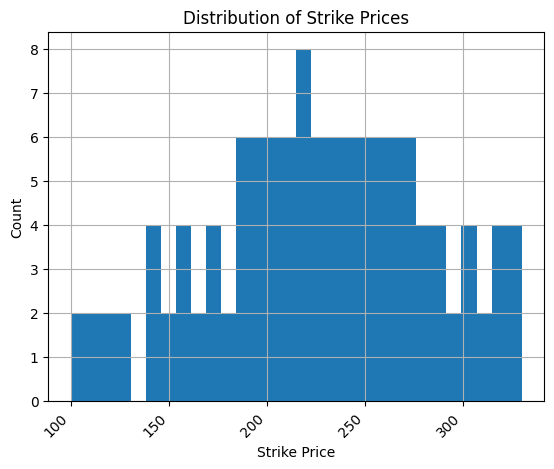

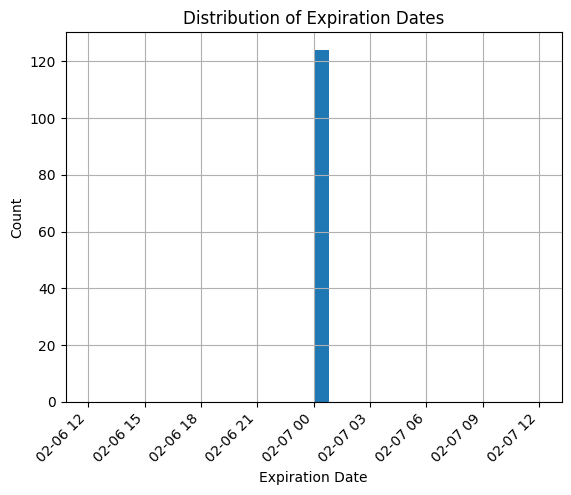

In [ ]:
ticker:str = 'AAPL'
exp_from:str = '2025-02-01'
exp_to:str = '2025-02-07'

##----------------------------------------

contracts_df = fetch_contracts_df(ticker, exp_from, exp_to)
describe_contracts(contracts_df)


